In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import wandb
import h5py

import numpy as np

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

import torch.nn as nn

from Data import ChannelJitter, RandomNoise, get_values
from Network import ASPP, ConvolutionBlock, Unet, ssim_loss

path = "datasets/" + "with_labels.hdf5"
device = "cuda"

IM = torch.tensor([ 0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5, 0.0]).to(device)

IS = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5, 1.0]).to(device)


val_transform = transforms.Compose([
    transforms.RandomCrop((64, 64)),
    transforms.Normalize(IM, IS),
])

train_transform = transforms.Compose([
    transforms.RandomApply([transforms.RandomRotation(360, interpolation=transforms.InterpolationMode.BILINEAR)], p=0.5),
    
    transforms.RandomCrop((64, 64)),
    transforms.Normalize(IM, IS),
    
    transforms.RandomApply([ChannelJitter(0.2, 0.2)], p=0.2),
    transforms.RandomApply([RandomNoise(0.2)], p=0.2),
])

with h5py.File(path, 'r') as f:
    images = list(f.keys())

images = [get_values(image) for image in images]
df = pd.DataFrame(images)

df_z = df[df["mean"] < 0.2].sample(frac=0.1, random_state=0)
df = pd.concat([df[df["mean"] >= 0.2], df_z])

df.head()

/home/alunos/.pyenv/versions/3.10.12/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,lat,lon,year,month,day,mean,filename
353,-3.35,-54.62,2017,7,1,0.25,Labeled_-3.35_-54.62_2017_07_01_0.25.npy
354,-3.35,-54.62,2017,8,1,0.33,Labeled_-3.35_-54.62_2017_08_01_0.33.npy
355,-3.35,-54.62,2018,6,1,0.31,Labeled_-3.35_-54.62_2018_06_01_0.31.npy
356,-3.35,-54.62,2018,8,1,0.35,Labeled_-3.35_-54.62_2018_08_01_0.35.npy
357,-3.35,-54.62,2019,7,1,0.37,Labeled_-3.35_-54.62_2019_07_01_0.37.npy


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        self.h5file = h5py.File(path, 'r')

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]
        img = self.h5file[filename][:]

        return torch.tensor(img)
    
    def __del__(self):
        self.h5file.close()
        

positions = df[["lat", "lon"]].drop_duplicates()
positions.sort_index(inplace=True)

# Results depend on validation set, so we fix the seed
train_positions = positions.sample(frac=0.8, random_state=0)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df)
val_dl = DataLoader(val_ds, batch_size=len(val_ds) * 4, shuffle=True)

test_dl = DataLoader(train_ds, batch_size=len(val_ds), shuffle=True)

val_ds.positions # 206, 393, ..., 17061, 17162

,lat,lon
206,-3.33,-55.02
393,-3.35,-54.68
407,-3.35,-54.72
418,-3.35,-54.74
451,-3.35,-54.90
...,...,...
16799,-4.37,-55.04
16938,-4.39,-54.60
16971,-4.39,-54.66
17061,-4.39,-54.94


In [3]:
#https://www.mdpi.com/2079-9292/11/1/130
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            ConvolutionBlock(8, 16),
            ASPP(16, 16),
        )

        self.unet = Unet(16 * 3, 16)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            #nn.Sigmoid() # Sigmoid is included in the loss
        )

    def forward(self, x):

        # x shape is (batch, 24, 64, 64)

        # Divide the second channel in x0, x1 and x2
        x0, x1, x2 = torch.split(x, 8, dim=1)
        x0 = self.enc(x0)
        x1 = self.enc(x1)
        x2 = self.enc(x2)

        # Concatenate the three channels
        x = torch.cat([x0, x1, x2], dim=1)

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x *= 1000000

        return x

model = Network().to(device)

In [4]:
@torch.no_grad()
def plot_images():
    data = next(iter(val_dl)).to(device)
    data = torch.stack([val_transform(d) for d in data])
    im, lb = data[:, :-1], data[:, [-1]]

    out = torch.sigmoid(model(im))

    im0 = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
    im0 = im0.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im1 = (im[0][11:14] * IS[11:14, None, None]) + IM[11:14, None, None]
    im1 = im1.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im2 = (im[0][19:22] * IS[19:22, None, None]) + IM[19:22, None, None]
    im2 = im2.permute(1, 2, 0).clip(0,1).cpu().numpy()

    label = lb[0][0].cpu().numpy()
    output = out[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(15, 10))
    axes[0].imshow(im0)
    axes[1].imshow(im1)
    axes[2].imshow(im2)
    axes[3].imshow(label, vmin=0, vmax=1)
    axes[4].imshow(output, vmin=0, vmax=1)
    plt.show()

In [5]:
@torch.no_grad()
def f1_score(dl):
    data = next(iter(val_dl)).to(device)
    data = torch.stack([val_transform(d) for d in data])
    im, lb = data[:, :-1], data[:, [-1]]

    output = torch.sigmoid(model(im))

    tp = torch.sum(output * lb)
    fp = torch.sum(output * (1-lb))
    fn = torch.sum((1-output) * lb)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)

    return float(f1)

In [6]:
ssim_factor = 2
bce_loss = nn.BCEWithLogitsLoss()
loss_fn = lambda output, target: bce_loss(output, target) + ssim_factor * ssim_loss(torch.sigmoid(output), target)

lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

epochs = 300
patience = 100

best_f1 = -torch.inf
best_model = model.state_dict()

In [7]:
wandb.init(
    project="Trees",

    config={
    "learning rate": lr,
    "epochs": epochs,
    "ssim factor": ssim_factor,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: danilolc (dnlmcrd). Use `wandb login --relogin` to force relogin


In [8]:
for i in tqdm(range(epochs)):

    # Train
    model.train()
    for data in train_dl:
        optimizer.zero_grad()

        data = data.to(device)
        data = torch.stack([train_transform(d) for d in data])
        im, lb = data[:, :-1], data[:, [-1]]

        out = model(im)
        loss = loss_fn(out, lb).mean()
        
        loss.backward()
        optimizer.step()
    
    # Eval
    with torch.no_grad():
        model.eval()

        f1_val = f1_score(val_dl)
        f1_train = f1_score(test_dl)
        wandb.log({"f1_train": f1_train, "f1_val": f1_val})

        if best_f1 < f1_val:
            best_f1 = f1_val
            best_model = model.state_dict()
            pat_count = 0

        pat_count = pat_count + 1
        if pat_count == patience:
            model.load_state_dict(best_model)
            break

  0%|          | 0/300 [00:00<?, ?it/s]/home/alunos/.pyenv/versions/3.10.12/envs/torch/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 300/300 [10:53<00:00,  2.18s/it]


In [9]:
wandb.finish()
print(best_f1)

f1_train,▁▃▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇█▇▇█▇▇▇█▇▇▇▇
f1_val,▁▃▅▅▆▆▆▇▆▇▇▇▇▆▇█▇██▇█▇▇▇█▇▇██▇██▇███▇█▇▇
f1_train,0.85803
f1_val,0.85422


0.8744043707847595


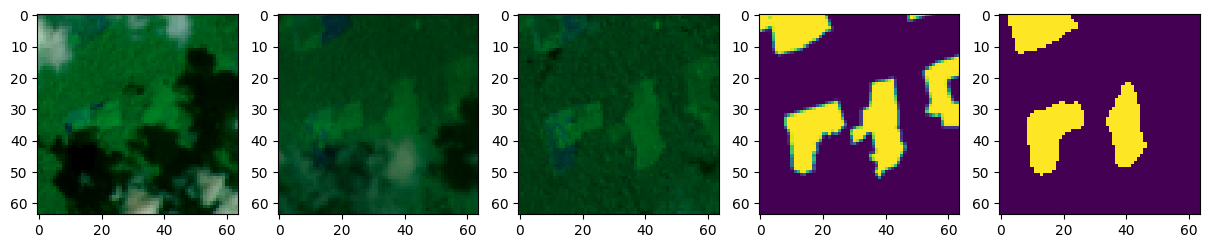

In [19]:
plot_images()